In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
num_per_class  = 1000
image_size = 91

x = np.linspace(-4, 4, image_size)
x, y = np.meshgrid(x, x)

images = torch.zeros(num_per_class, 1, image_size, image_size)
labels = torch.zeros(num_per_class, 3)

for i in range(num_per_class):
    location = np.max(x)/2 * np.random.randn(2)
    radius = np.random.rand()*10 + 5

    gaussian = np.exp(-((x - location[0])**2 + (y - location[1])**2)/radius)
    gaussian = gaussian + np.random.randn(image_size,image_size)/10

    images[i,:,:,:] = torch.Tensor(gaussian).view(1, image_size, image_size)
    labels[i,:] = torch.Tensor([location[0], location[1], radius])

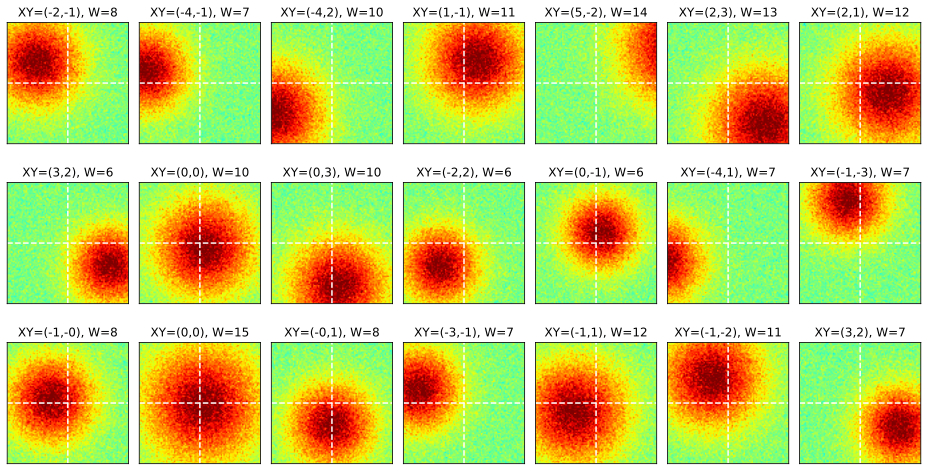

In [3]:
fig,axs = plt.subplots(3,7,figsize=(13,7))

for i,ax in enumerate(axs.flatten()):
    pic = np.random.randint(num_per_class)
    gaussian = np.squeeze(images[pic,:,:])
    ax.imshow(gaussian, vmin=-1, vmax=1, cmap='jet', extent=[-4,4,-4,4])
    ax.set_title(f'XY=({labels[pic,0]:.0f},{labels[pic,1]:.0f}), W={labels[pic,2]:.0f}')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [4]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.2, random_state=17)

train_data = TensorDataset(train_data, train_label)
test_data = TensorDataset(test_data, test_label)

batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
def model():
    
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
            
            self.conv2 = nn.Conv2d(6, 4, 3, padding=1)
            
            self.fc1 = nn.Linear(22*22*4, 50)
            
            self.out = nn.Linear(50, 3)
        
        def forward(self, x):
            
            x = self.conv1(x)
            x = f.relu(x)
            x = f.avg_pool2d(x, (2, 2))
            
            x = self.conv2(x)
            x = f.relu(x)
            x = f.avg_pool2d(x, (2, 2))
            
            x = x.reshape(x.shape[0], -1)
            
            x = self.fc1(x)
            x = f.relu(x)
            
            return self.out(x)
        
    cnn = CNN()
    
    loss_fun = nn.MSELoss()
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
    
    return cnn, loss_fun, optimizer

In [6]:
summary(model()[0].to(device="cuda:0"), (1, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
            Linear-3                   [-1, 50]          96,850
            Linear-4                    [-1, 3]             153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [7]:
def train_model():
    
    num_epochs = 30

    cnn, loss_fun, optimizer = model()
    
    train_loss = []
    test_loss = []
    
    for epoch in range(num_epochs):
        
        batch_loss = []
        
        for x, y in train_loader:
            y_hat = cnn(x)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
        train_loss.append(np.mean(batch_loss))
        
        x, y = next(iter(test_loader))
        
        with torch.no_grad():
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)
        
        test_loss.append(loss.item())
        
    return train_loss, test_loss, cnn

In [8]:
train_loss, test_loss, cnn = train_model()

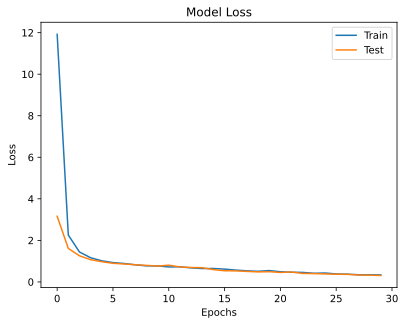

In [9]:
plt.plot(train_loss, "-", label="Train")
plt.plot(test_loss, "-", label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend();

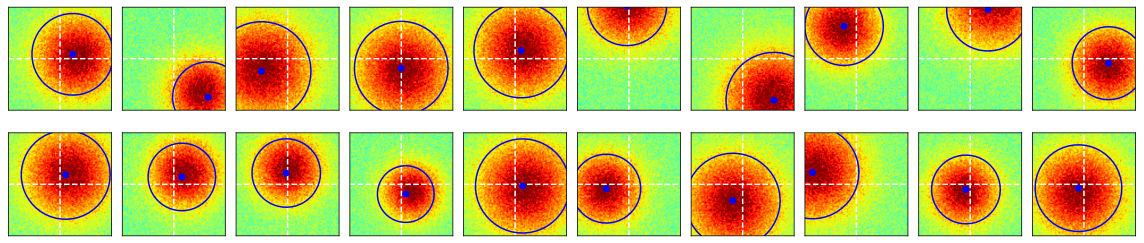

In [10]:
image, y = next(iter(test_loader))
y_hat = cnn(image)

_, axis = plt.subplots(2,10,figsize=(16,4))

theta = np.linspace(0, 2*np.pi)

for i, ax in enumerate(axis.flatten()):
    gaussian = torch.squeeze(image[i, 0, :, :]).detach()
    ax.imshow(gaussian, vmin=-1, vmax=1, cmap='jet', extent=[-4,4,-4,4], origin='lower')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')

    cx = y_hat[i][0].item()
    cy = y_hat[i][1].item()
    rd = y_hat[i][2].item()

    x = cx + np.cos(theta)*np.sqrt(rd)
    y = cy + np.sin(theta)*np.sqrt(rd)
    ax.plot(x,y,'b')
    ax.plot(cx,cy,'bo')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])

plt.tight_layout();